In [1]:
!wget https://zenodo.org/records/16948350/files/WHU_buildings.zip?download=1 -O WHU_buildings.zip
# Unzip
!unzip -q WHU_buildings.zip -d ./WHU_buildings

--2025-08-26 11:05:50--  https://zenodo.org/records/16948350/files/WHU_buildings.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116403828 (111M) [application/octet-stream]
Saving to: ‘WHU_buildings.zip’

WHU_buildings.zip   100%[===================>] 111.01M  2.66MB/s    in 78s     

2025-08-26 11:07:09 (1.41 MB/s) - ‘WHU_buildings.zip’ saved [116403828/116403828]



In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# --- 1. Set paths (adjust to your download) ---
img_dir = "/content/WHU_buildings/Satellite dataset вё (global cities)/image"   # raw aerial images
mask_dir = "/content/WHU_buildings/Satellite dataset вё (global cities)/label"   # corresponding building masks

In [3]:

# --- 2. Load data ---
X, Y = [], []
files = sorted(os.listdir(img_dir))

for f in files:
    img = imread(os.path.join(img_dir, f))
    mask = imread(os.path.join(mask_dir, f.replace(".jpg", ".png"))).max(axis=-1)  # adjust ext

    # ensure mask is binary (0=background, 1=building)
    mask = (mask > 127).astype(np.uint8)

    X.append(img)
    Y.append(mask[..., np.newaxis])  # keep channel dimension

X = np.array(X, dtype=np.float32) / 255.0
Y = np.array(Y, dtype=np.float32)

print("Images:", X.shape, "Masks:", Y.shape)

# --- 3. Train/test split ---
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


Images: (204, 512, 512, 3) Masks: (204, 512, 512, 1)


In [4]:

# --- 4. Define U-Net model ---
def unet(input_size=(512,512,3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(256, 3, activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(512, 3, activation="relu", padding="same")(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(256, 2, strides=(2,2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(256, 3, activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(128, 2, strides=(2,2), padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(128, 3, activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(64, 2, strides=(2,2), padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(64, 3, activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(32, 2, strides=(2,2), padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, 3, activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(32, 3, activation="relu", padding="same")(c9)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c9)

    return models.Model(inputs, outputs)

model = unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 5. Train ---
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=8, epochs=100
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


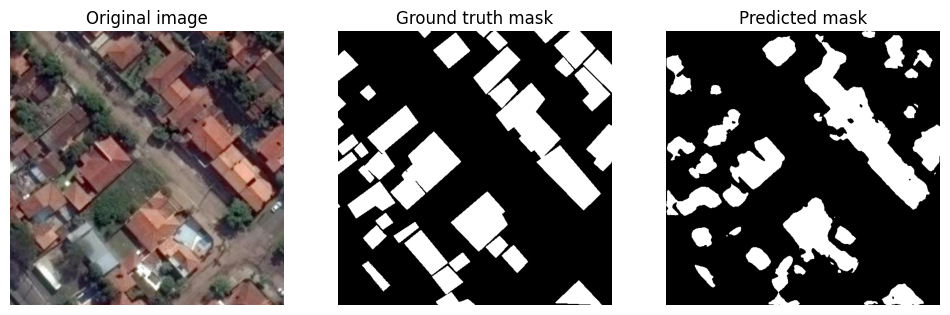

In [8]:

# --- 6. Inference ---
idx = np.random.randint(0, len(X_test))
test_img = X_test[idx]
true_mask = Y_test[idx].squeeze()
pred_mask = (model.predict(test_img[np.newaxis,...])[0,...,0] > 0.5).astype(np.uint8)

# --- 7. Plot results ---
fig, axs = plt.subplots(1, 3, figsize=(12,5))
axs[0].imshow(test_img)
axs[0].set_title("Original image")
axs[0].axis("off")

axs[1].imshow(true_mask, cmap="gray")
axs[1].set_title("Ground truth mask")
axs[1].axis("off")

axs[2].imshow(pred_mask, cmap="gray")
axs[2].set_title("Predicted mask")
axs[2].axis("off")

plt.show()